# Shifting Mean Anomaly

In [1]:
import matplotlib.pyplot as plt
plt.style.use('rcparams.mplstyle')
import matplotlib as mpl
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import astropy.constants as aconst
from calcwf import gen_wf, chirp2total, peri_advance_orbit, shifted_f, shifted_e

The plot in this notebook demonstrates a waveform starting $2\pi$ earlier in mean anomaly by calculating the change in frequency and eccentricity to recover the original waveform after exactly one amplitude modulation.

In [2]:
# Parameters
f_low = 10
e = 0.2
chirp = 24
q = 2
sample_rate = 4096

In [3]:
# Create original waveform
h = gen_wf(f_low, e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS')

# Calculate shifts in frequency and eccentricity
s_f = shifted_f(f_low, e, chirp2total(chirp, q), q)
s_e = shifted_e(s_f, f_low, e)

# Create shifted waveform
s = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS')

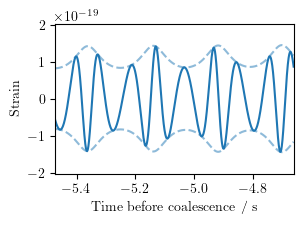

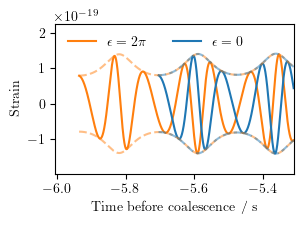

In [4]:
# Make plot of original waveform
plt.figure(figsize=(0.49*6.4,0.49*4.8))
plt.plot(h.sample_times, h.real(), c='C0')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Strain')
len_2pi = h.sample_times[0]-s.sample_times[0]
plt.xlim(h.sample_times[0]+1*len_2pi, h.sample_times[0]+4.5*len_2pi)
max_h = max(np.abs(h[:int(4.5*len_2pi*sample_rate)]))
plt.ylim(-1.4*max_h, 1.4*max_h)
plt.tight_layout()
plt.savefig('Figures/EccWF.pgf')
plt.show()

# Make plot, shifting 2 pi in mean anomaly
plt.figure(figsize=(0.49*6.4,0.49*4.8))
plt.plot(s.sample_times, s.real(), c='C1', label='$\epsilon=2\pi$')
plt.plot(h.sample_times, h.real(), c='C0', label='$\epsilon=0$')
plt.plot(s.sample_times, np.abs(s), c='C1', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.plot(s.sample_times, -np.abs(s), c='C1', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.legend(loc='upper left', frameon=False, ncol=2)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Strain')
len_2pi = h.sample_times[0]-s.sample_times[0]
plt.xlim(s.sample_times[0]-0.3*len_2pi, h.sample_times[0]+1.7*len_2pi)
max_h = max(np.abs(h[:int(1.7*len_2pi*sample_rate)]))
plt.ylim(-1.4*max_h, 1.6*max_h)
plt.tight_layout()
plt.savefig('Figures/2piMA.pgf')

## Beat approximation

We can approximate the inspiral portion of an eccentric signal as 
$$
h_\mathrm{inspiral} \approx \alpha \cos{2\omega_\mathrm{orb}t} \left[1+\beta\cos{\omega_\mathrm{ap}t}\right]
$$

In [5]:
#  Beat parameters
alpha_m = 0
alpha_c = 1.17e-19
beta_m = 0
beta_c = -0.2
t0 = -0.035

In [6]:
# Gets orbital frequency from gravitational wave frequency
def f_orb(f_gw):
    return f_gw/2

# Gets apsidal advance frequency from gravitational wave frequency
def f_ap(f_gw, f_ref, ecc, M):
    P_orb = 1/f_orb(f_gw)
    e = shifted_e(f_gw, f_ref, ecc)
    peri_advance_per_orb = peri_advance_orbit(P_orb, e, M*aconst.M_sun.value)
    P_ap = P_orb*2*np.pi/peri_advance_per_orb
    return 1/P_orb - 1/P_ap

In [7]:
# Track gw frequency from max power in qtransform
h_q_times, h_q_freqs, h_q_plane = h.real().qtransform(1/sample_rate, logfsteps=300, qrange=(50,50), frange=(f_low, 100))
h_q_amp = h_q_plane**0.5
h_q_amp = (h_q_amp.T / np.max(h_q_amp, axis=1)).T
t = h_q_times[:-int(25*sample_rate/512):int(10*sample_rate/512)]
f_gw = h_q_freqs[np.argmax(h_q_amp, axis=0)[:-int(25*sample_rate/512):int(10*sample_rate/512)]]
f_gw = np.convolve(f_gw, np.ones(11), "valid")/11
t = t[5:-5]

# Set up frequencies for 'beat' waveform
f_o = f_orb(f_gw)
f_a = f_ap(f_gw, f_low, e, chirp2total(chirp, q))
f_o_interp = interp1d(t-h.sample_times[0], f_o, fill_value='extrapolate')
f_a_interp = interp1d(t-h.sample_times[0], f_a, fill_value='extrapolate')
t = np.array(h.sample_times[int(10*len_2pi*sample_rate):int(13*len_2pi*sample_rate)])-h.sample_times[0]
f_o = f_o_interp(t)
f_a = f_a_interp(t)

(-1.9885433289013626e-19, 1.9885433289013626e-19)

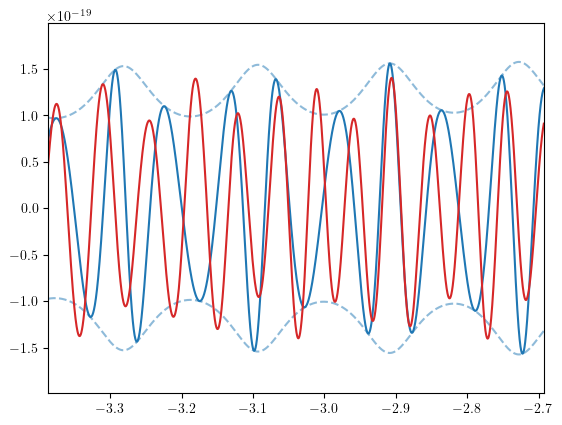

In [8]:
# Create approximate 'beat' waveform
def beat_waveform(alpha_m, alpha_c, beta_m, beta_c, t0):

    # Calculate alpha and beta for all times
    alpha = alpha_m*(t+t0) + alpha_c
    beta = beta_m*(t+t0) + beta_c
    
    # Create array
    amp_mods = 1+beta*np.cos(2*np.pi*f_a*(t+t0))
    b_arr = alpha*np.cos(4*np.pi*f_o*(t+t0))*amp_mods
    return b_arr

b_arr = beat_waveform(alpha_m, alpha_c, beta_m, beta_c, t0)
plt.plot(h.sample_times, h.real(), c='C0')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.plot(t+h.sample_times[0], b_arr, c='C3')
plt.xlim(h.sample_times[0]+10*len_2pi, h.sample_times[0]+13*len_2pi)
plt.ylim(-1.4*max_h, 1.4*max_h)